In [1]:
import os
import time
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import albumentations as a

In [2]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2024)

In [3]:
class cfg:
    WORKING_DIR = Path(os.getcwd()).parent
    RELATIVE_PATH = "Data"
    BASE_PATH = WORKING_DIR / RELATIVE_PATH
    CSV_PATH = BASE_PATH/'train.csv'
    SEMI_PATH = BASE_PATH/'train_semi_supervised'
    CELL_TYPE = ['shsy5y', 'astro', 'cort']
    WIDTH, HEIGHT =  704, 520
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_BATCH_SIZE = 2
    VALID_BATCH_SIZE = 1
    LR = 0.001
    EPOCHS=100
    MASK_THRESHOLD = 0.5
    KFOLD = 5
    NUM_CLASSES = 2
    BOX_DETECTIONS_PER_IMG = 539
    DEVICE = 'cuda'
    NORMALIZE = True

In [4]:
cfg.BASE_PATH

PosixPath('/player/workspace/cell-instance-segmentation/Data')

In [5]:
# These are slight redefinitions of torch.transformation classes
# The difference is that they handle the target and the mask
# Copied from Abishek, added new ones
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, cfg.MEAN, cfg.STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if cfg.NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for train
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

# Dataset

In [6]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


In [7]:
class CellDataset(Dataset):
    def __init__(self, df, transforms=None, resize=False):
        self.transforms = transforms
        self.df = df

        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(cfg.HEIGHT * resize)
            self.width = int(cfg.WIDTH * resize)
        else:
            self.height = cfg.HEIGHT
            self.width = cfg.WIDTH

        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')[['annotation', 'image_path']].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                'image_id': row['id'],
                'image_path': row['image_path'][0],
                'annotations': row["annotation"]
            }

    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        img_path = self.image_info[idx]["image_path"]
        
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None
        
        if self.should_resize:
            img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []

        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (cfg.HEIGHT, cfg.WIDTH))
            a_mask = Image.fromarray(a_mask)

            if self.should_resize:
                a_mask = a_mask.resize((self.width, self.height), resample=Image.BILINEAR)

            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask

            boxes.append(self.get_box(a_mask))

        # dummy labels
        labels = [1 for _ in range(n_objects)]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # This is the required target for the Mask R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [8]:
df = pd.read_csv(cfg.CSV_PATH) 
df['image_path'] = df['id'].apply(lambda x : (cfg.BASE_PATH/'train'/x).with_suffix('.png'))


In [9]:
unique_id, idxes = np.unique(df['id'].values, return_index=True)
cell_types = df.iloc[idxes]['cell_type'].values

skf = StratifiedKFold(n_splits=cfg.KFOLD)
for i, (train_index, test_index) in enumerate(skf.split(unique_id,cell_types)):
    df.loc[df['id'].isin(unique_id[test_index]),'fold'] = i 
    
duplicat_list = []
for i in range(cfg.KFOLD): 
    for j in range(cfg.KFOLD): 
        fdf = df[df['fold'] == i]
        sdf = df[df['fold'] == j]
        
        duplicat_list.append(len(set(fdf['id']).intersection(sdf['id'])))

duplite_metric = np.array(duplicat_list).reshape((cfg.KFOLD,cfg.KFOLD))
print(duplite_metric)

[[122   0   0   0   0]
 [  0 121   0   0   0]
 [  0   0 121   0   0]
 [  0   0   0 121   0]
 [  0   0   0   0 121]]


In [10]:
train_df = df.query('fold != 4')
valid_df = df.query('fold == 4')

In [11]:
ds_train = CellDataset(train_df, resize=False, transforms=get_transform(train=True))
image, annot = ds_train[0]
dl_train = DataLoader(ds_train, batch_size=cfg.TRAIN_BATCH_SIZE, shuffle=True, 
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


ds_val = CellDataset(valid_df, resize=False, transforms=get_transform(train=False))
dl_val = DataLoader(ds_val, batch_size=cfg.VALID_BATCH_SIZE, shuffle=False, 
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


print(annot['masks'].shape)

torch.Size([395, 520, 704])


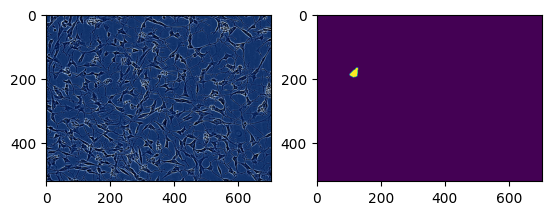

In [12]:
fig,axs = plt.subplots(1,2)

axs[0].imshow(image.permute((1,2,0)))
axs[1].imshow(annot['masks'][0])

In [13]:
def get_model():
    if cfg.NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, 
                                                                   box_detections_per_img=cfg.BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=cfg.MEAN, 
                                                                   image_std=cfg.STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                  box_detections_per_img=cfg.BOX_DETECTIONS_PER_IMG)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, cfg.NUM_CLASSES)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, cfg.NUM_CLASSES)
    return model


# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS
model = get_model()
model.to(cfg.DEVICE)

# TODO: try removing this for
for param in model.parameters():
    param.requires_grad = True
    
model.train()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=cfg.LR, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_mask_losses = []

best_valid_loss = 10000

for epoch in range(1, cfg.EPOCHS + 1):
    print(f"Starting epoch {epoch} of {cfg.EPOCHS}")
    
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
    
        # Predict
        images = list(image.to(cfg.DEVICE) for image in images)
        targets = [{k: v.to(cfg.DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        loss_classifier_accum  += loss_dict['loss_classifier'].item()
        
        if batch_idx % 100 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")
    

    lr_scheduler.step()
    
    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches
    
    elapsed = time.time() - time_start
    
    
    prefix = f"[Epoch {epoch:2d} / {cfg.EPOCHS:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")
    
    # Validation
    val_loss_accum = 0
    val_loss_mask_accum = 0
    val_loss_classifier_accum = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(cfg.DEVICE) for image in images)
            targets = [{k: v.to(cfg.DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    # Validation losses
    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    val_loss_classifier = val_loss_classifier_accum / n_batches_val
    elapsed = time.time() - time_start

    validation_mask_losses.append(val_loss_mask)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        print(f"Best val Score : {best_valid_loss}")
        torch.save(model.state_dict(), f"rcnn{best_valid_loss}-e{epoch}.pth")

    prefix = f"[Epoch {epoch:2d} / {cfg.EPOCHS:2d}]"
    print(prefix)
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
    print(f"{prefix} Val mask-only loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
    print(prefix)
    print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
    print(prefix)


Starting epoch 1 of 100


In [ ]:
def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    
    return iou  

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = mask_threshold_dict[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

In [ ]:
mask_threshold_dict = {1: 0.55, 2: 0.75, 3:  0.6}
min_score_dict = {1: 0.55, 2: 0.75, 3: 0.5}

def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []   
    for i, mask in enumerate(pred["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    maskimg = np.zeros((cfg.HEIGHT, cfg.WIDTH))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg
# Plots: the image, The image + the ground truth mask, The image + the predicted mask

def analyze_train_sample(model, ds_train, sample_index):
    
    img, targets = ds_train[sample_index]
    #print(img.shape)
    l = np.unique(targets["labels"])
    ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"cell type {l}")
    ax[0].axis("off")
    
    masks = combine_masks(targets['masks'], 0.5)
    #plt.imshow(img.numpy().transpose((1,2,0)))
    ax[1].imshow(masks)
    ax[1].set_title(f"Ground truth, {len(targets['masks'])} cells")
    ax[1].axis("off")
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(cfg.DEVICE)])[0]
    
    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
    lstr = ""
    for i in l.index:
        lstr += f"{l[i]}x{i} "
    #print(l, l.sort_values().index[-1])
    #plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    mask_threshold = mask_threshold_dict[l.sort_values().index[-1]]
    #print(mask_threshold)
    pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
    ax[2].imshow(pred_masks)
    ax[2].set_title(f"Predictions, labels: {lstr}")
    ax[2].axis("off")
    plt.show() 
    
    #print(masks.shape, pred_masks.shape)
    score = iou_map([masks],[pred_masks])
    print("Score:", score)    
    
    
# NOTE: It puts the model in eval mode!! Revert for re-training
analyze_train_sample(model, ds_val, 20)
